In [1]:
import numpy as np

import matplotlib
matplotlib.rc('savefig', dpi=100, format='svg')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
import torch
import torch.nn as nn

## Same old dataset

In [3]:
num_points = 75
# X1 = np.linspace(-2.5, 1.9, num_points)
X1 = np.linspace(-2.5, 2.5, num_points)
X2 = np.linspace(-2.5, 3, num_points)
# X2 = np.linspace(-2.2, 2.1, num_points)
X1, X2 = np.meshgrid(X1, X2)

Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1. - 0.1*(X1)+0.02*(X2)
Y = -Y
# Y = np.sqrt(X1**2 + X2**2)

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1

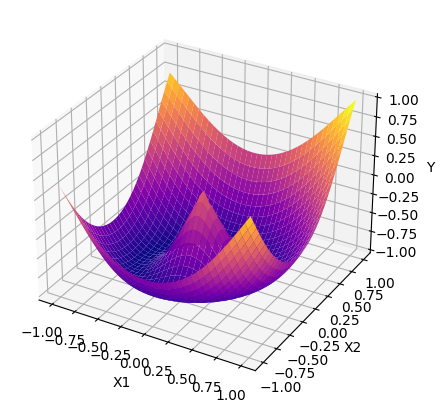

In [4]:
x1 = X1.reshape(-1)
x2 = X2.reshape(-1)
y = Y.reshape(-1)

xx = np.c_[x1, x2]
yy = Y.reshape(-1,1)
xx, yy = torch.FloatTensor(xx), torch.FloatTensor(yy)


%matplotlib inline
fig = plt.figure(figsize=(7,5))
ax = plt.axes(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [5]:
class GatedLinearUnit(nn.Module):
    def __init__(self, input_dim, output_dim, bias=True):
        super().__init__()
        self.gate = nn.Linear(input_dim, output_dim, bias=bias)
        self.value = nn.Linear(input_dim, output_dim, bias=bias)
        
class SigGLU(GatedLinearUnit):
    
    def forward(self, x):
        return torch.sigmoid(self.gate(x))*self.value(x)

In [39]:
def swish1(x, beta=2.5):
    z = torch.sigmoid(beta*x)
    y = x * z
    return y/1.1

class SwiGLU(GatedLinearUnit):
    
    def forward(self, x):
        return swish1(self.gate(x), beta=2.5)*self.value(x)

In [7]:
torch.manual_seed(103)

h = 1
net = nn.Sequential(
            SwiGLU(2, h),
#             SigGLU(2, h),
            nn.Linear(h, 1),
)

In [8]:
# device = torch.device("cuda:0")
device = torch.device("cpu")

In [9]:
xx, yy = xx.to(device), yy.to(device)
net.to(device)

Sequential(
  (0): SwiGLU(
    (gate): Linear(in_features=2, out_features=1, bias=True)
    (value): Linear(in_features=2, out_features=1, bias=True)
  )
  (1): Linear(in_features=1, out_features=1, bias=True)
)

In [10]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [11]:
# fig = plt.figure(figsize=(9,8))
# ax = plt.axes(projection='3d')

for epoch in range(5000):

    yout = net(xx)
    loss =criterion(yout, yy)
    optimizer.zero_grad()
    
    loss.backward()
    optimizer.step()
    
    if epoch%200 == 0:
        error = float(loss)
        print(f'Epoch:{epoch} | Error:{error}')
#         ax.clear()
        
#         ax.scatter(X1, X2, Y)
#         yout_ = yout.reshape(Y.shape)
#         ax.scatter(X1, X2, yout_, color='r', marker='.')
#         ax.set_xlabel('X1')
#         ax.set_ylabel('X2')
#         ax.set_zlabel('Y')
        
#         fig.canvas.draw()
#         plt.pause(0.01)

Epoch:0 | Error:0.17243769764900208
Epoch:200 | Error:0.1414261758327484
Epoch:400 | Error:0.1249333992600441
Epoch:600 | Error:0.1136283203959465
Epoch:800 | Error:0.09600188583135605
Epoch:1000 | Error:0.08707893639802933
Epoch:1200 | Error:0.08353183418512344
Epoch:1400 | Error:0.08188991248607635
Epoch:1600 | Error:0.08087702095508575
Epoch:1800 | Error:0.08010808378458023
Epoch:2000 | Error:0.0795077532529831
Epoch:2200 | Error:0.07905057817697525
Epoch:2400 | Error:0.07870588451623917
Epoch:2600 | Error:0.07844427973031998
Epoch:2800 | Error:0.0782432034611702
Epoch:3000 | Error:0.07808631658554077
Epoch:3200 | Error:0.07796183973550797
Epoch:3400 | Error:0.07786115258932114
Epoch:3600 | Error:0.07777805626392365
Epoch:3800 | Error:0.07770802080631256
Epoch:4000 | Error:0.07764777541160583
Epoch:4200 | Error:0.07759498059749603
Epoch:4400 | Error:0.07754789292812347
Epoch:4600 | Error:0.07750526070594788
Epoch:4800 | Error:0.07746618986129761


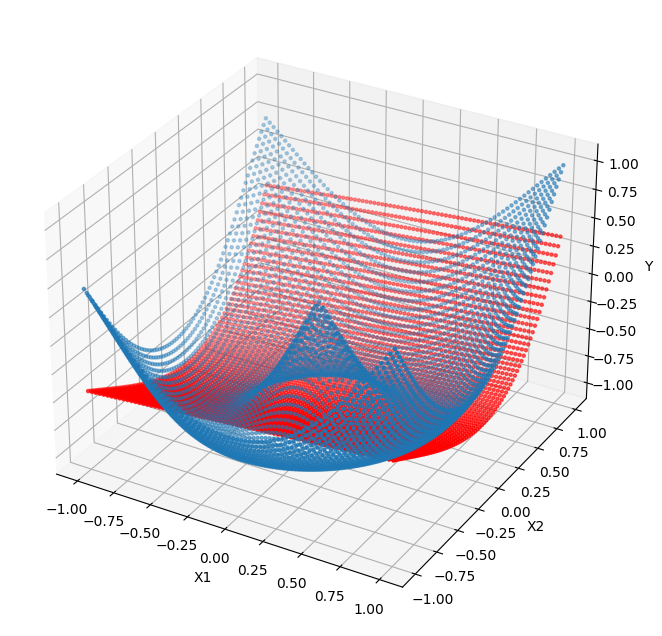

In [12]:
%matplotlib inline

yout_ = yout.data.cpu().reshape(Y.shape)

fig = plt.figure(figsize=(9,8))
ax = plt.axes(projection='3d')
ax.scatter(X1, X2, Y, marker= '.')
ax.scatter(X1, X2, yout_, color='r', marker='.')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.pause(10)
plt.show()

## plot activation function

In [36]:
num_points = 50
X1 = np.linspace(-2, 6, num_points)
X2 = np.linspace(-4, 4, num_points)
X1, X2 = np.meshgrid(X1, X2)

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)
xx = np.c_[x1, x2]
xx = torch.FloatTensor(xx)

In [44]:
torch.random.manual_seed(123)

glu = SigGLU(2, 1)
# glu = SwiGLU(2, 1)


## hilight the non-linearity
glu.gate.weight.data.abs_()
glu.value.weight.data.abs_()

glu.gate.weight.data *= 5.
glu.value.weight.data *= 2.

# glu.gate.weight.data *= 2.
# glu.value.weight.data *= 0.2

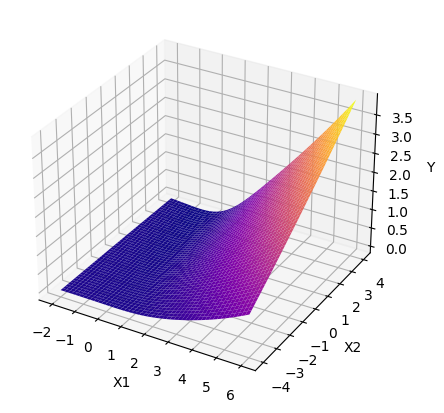

In [45]:
a = glu(xx).data

# %matplotlib tk
%matplotlib inline
fig = plt.figure(figsize=(7,5))
ax = plt.axes(projection='3d')
ax.plot_surface(X1, X2, a.reshape(X1.shape), cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
# plt.pause(10)
plt.show()

In [25]:
glu.value.weight.data

tensor([[0.5333, 1.2050]])

In [17]:
asdasd

NameError: name 'asdasd' is not defined

In [47]:
# fig = plt.figure(figsize=(7,6))
# ax = plt.axes(projection='3d')

# %matplotlib inline
%matplotlib tk

fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)
ax.azim = -60
ax.elev = 38

def plot_surface_func(a):
    a = a.reshape(X1.shape)
    
    ax.clear()
    ax.plot_surface(X1, X2, a, cmap='viridis', alpha=1.0)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('Y')
    ax.set_zlim(-4,8)
    
    ax2.clear()
    ax2.contourf(X1, X2, a, levels=20)
    ax2.contour(X1, X2, a, colors="k", levels=20)
    
    w = glu.gate.weight.data[0].numpy()
    v = glu.value.weight.data[0].numpy()
    ax2.text(X1.min()- 3, X2.max()-1, f"""W=[{w[0]:.2f}] V=[{v[0]:.2f}]
      [{w[1]:.2f}]      [{v[1]:.2f}]""")
    
    
    fig.canvas.draw()
    plt.pause(0.01)

    
# plot_surface_func(glu(xx).data)
# plt.close()

a = 0.1
b = 0.05
N = 5
for j in range(2):
    for i in range(N):
        glu.gate.weight.data[0,j] += a
        plot_surface_func(glu(xx).data)
    for i in range(N):
        glu.gate.weight.data[0,j] -= a
        plot_surface_func(glu(xx).data)
    for i in range(N):
        glu.gate.weight.data[0,j] -= a
        plot_surface_func(glu(xx).data)
    for i in range(N):
        glu.gate.weight.data[0,j] += a
        plot_surface_func(glu(xx).data)

for j in range(2):
    for i in range(N):
        glu.value.weight.data[0,j] -= b
        plot_surface_func(glu(xx).data)
    for i in range(N):
        glu.value.weight.data[0,j] += b
        plot_surface_func(glu(xx).data)
    for i in range(N):
        glu.value.weight.data[0,j] += b
        plot_surface_func(glu(xx).data)
    for i in range(N):
        glu.value.weight.data[0,j] -= b
        plot_surface_func(glu(xx).data)
    
plt.close()

## Animate

In [ ]:
from matplotlib import animation, rc

rc('animation', html='jshtml')
rc('savefig', dpi=100, format='jpg')
matplotlib.rcParams['animation.embed_limit'] = 2**128

In [ ]:
frame_outputs = [] ## a, w, v
N = 10
for j in range(2):
    for i in range(N):
        glu.gate.weight.data[0,j] += 0.3
        frame_outputs.append([glu(xx).data, glu.gate.weight.data.numpy().copy(), glu.value.weight.data.numpy().copy()])
    for i in range(N):
        glu.gate.weight.data[0,j] -= 0.3
        frame_outputs.append([glu(xx).data, glu.gate.weight.data.numpy().copy(), glu.value.weight.data.numpy().copy()])
    for i in range(N):
        glu.gate.weight.data[0,j] -= 0.3
        frame_outputs.append([glu(xx).data, glu.gate.weight.data.numpy().copy(), glu.value.weight.data.numpy().copy()])
    for i in range(N):
        glu.gate.weight.data[0,j] += 0.3
        frame_outputs.append([glu(xx).data, glu.gate.weight.data.numpy().copy(), glu.value.weight.data.numpy().copy()])

for j in range(2):
    for i in range(N):
        glu.value.weight.data[0,j] -= 0.1
        frame_outputs.append([glu(xx).data, glu.gate.weight.data.numpy().copy(), glu.value.weight.data.numpy().copy()])
    for i in range(N):
        glu.value.weight.data[0,j] += 0.1
        frame_outputs.append([glu(xx).data, glu.gate.weight.data.numpy().copy(), glu.value.weight.data.numpy().copy()])
    for i in range(N):
        glu.value.weight.data[0,j] += 0.1
        frame_outputs.append([glu(xx).data, glu.gate.weight.data.numpy().copy(), glu.value.weight.data.numpy().copy()])
    for i in range(N):
        glu.value.weight.data[0,j] -= 0.1
        frame_outputs.append([glu(xx).data, glu.gate.weight.data.numpy().copy(), glu.value.weight.data.numpy().copy()])

In [ ]:
len(frame_outputs)

In [ ]:
# for i in range(10):
#     print(frame_outputs[i][1:])

In [ ]:
# v = glu.gate.weight.data.numpy()

In [ ]:
# v.copy() is v

In [ ]:
# %matplotlib tk

fig = plt.figure(figsize=(14,6))
ax = fig.add_subplot(121,projection='3d')
ax2 = fig.add_subplot(122)
ax.azim = -60
ax.elev = 38

plt.close()

def plot_surface_func2(a, w, v):
    a = a.reshape(X1.shape)
    
    ax.clear()
    ax.plot_surface(X1, X2, a, cmap='viridis', alpha=1.0)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('Y')
    ax.set_zlim(-4,8)
    
    ax2.clear()
    ax2.contourf(X1, X2, a, levels=20)
    ax2.contour(X1, X2, a, colors="k", levels=20)
    
    ax2.text(X1.min()- 3, X2.max()-1, f"""W=[{w[0]:.2f}] V=[{v[0]:.2f}]
      [{w[1]:.2f}]      [{v[1]:.2f}]""")
    
#     fig.canvas.draw()
#     plt.pause(0.01)

def animate(i):
    global frame_outputs
    a, w, v = frame_outputs[i]
#     print(w, v)
    plot_surface_func2(a, w[0], v[0])


anim = animation.FuncAnimation(fig, animate,frames=len(frame_outputs),
                               init_func=lambda:None, interval=100)

In [ ]:
# anim

In [ ]:
# writer_gif = animation.ImageMagickWriter(fps=4)
# anim.save('glu_sigmoid.gif', writer=writer_gif, dpi=100)

In [ ]:
writer_mp4 = animation.FFMpegWriter(fps=6)
anim.save('swiglu_sigmoid.mp4', writer=writer_mp4)